# Intro

Pada kuis ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset Labeled Face in Wild (LFW).
Spesifikasi pengerjaan kuis yang harus dipehuni adalah,

1. Setiap label dari dataset LFW harus berisikan minimal 10 gambar (5 poin)
2. Citra yang digunakan merupakan citra RGB / color (5 poin)
3. (Opsional) Lakukan proses pra pengolahan data jika diperlukan (ekstra 10 poin)
4. (Wajib) Gunakan fitur histogram untuk setiap channel citra (35 poin)
5. (Wajib) Gunakan algoritma SVM sebagai model dasar (35 poin)
6. (Wajib) Gunakan metric akurasi, dan *classification report* untuk melihat performa model (20 poin)

# Challenge
Setelah menyelesaikan kuis berdasarkan spesifikasi wajib, Anda diperkenankan untuk

- Menggunakan fitur lain selain histogram (ekstra 20 poin)
- Menggunakan model lain selain SVM (ekstra 10 poin)
- Evalusi dengan metric lain ataupun report dengan *confusion matrix* (ekstra 10 poin)

## Boilerplate

Berikut merupakan boilerplate code yang dapat Anda gunakan sebagai acuan dasar pengerjaan kuis.
Anda diperkenankan untuk **menambah** ataupun **mengurangi** bagian boilerplate yang disediakan.

---

### Preparation

In [1]:
# Load required library
# Import Required Library
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

### Load Data
Dataset yang digunakan adalah Labeled Faces in the Wild (LFW) yang berisi gambar wajah. Kumpulan data ini diimpor dari sklearn.datasets menggunakan Fetch_lfw_people. Dataset ini akan digunakan untuk melatih model yang mengenali dan mengklasifikasikan wajah berdasarkan identitasnya.

In [2]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True
# Perbesar ukuran dataset dengan menambahkan parameter min_faces_per_person=200
faces = fetch_lfw_people(min_faces_per_person=200, color=True)

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')

Total Label: 2
Data dimension: (766, 62, 47, 3)
Images flatten dimension: (766, 8742)


Kode ini bertujuan untuk menampilkan 15 gambar wajah acak dengan menggunakan `np.random.randint`, kode ini secara acak memilih 15 indeks dari dataset gambar, memastikan variasi dalam tampilan wajah yang ditampilkan.

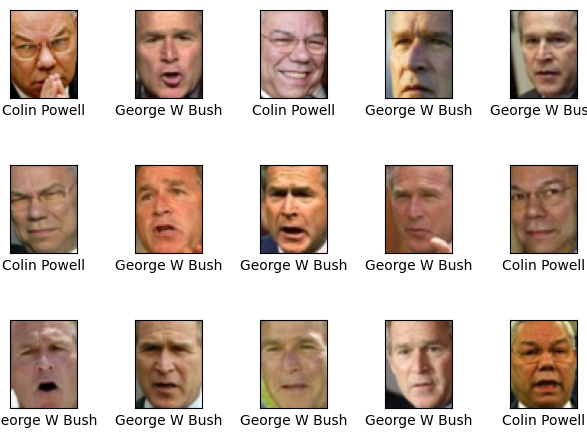

In [3]:
# Check by Plotted Images
# Generate random 15 images
rand_labels = [np.random.randint(0, len(faces.data)) for x in range(0,15)]

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

### Preprocessing

Pada tahap ini melakukan pengestrakan fitur histogram dari gambar rgb dengan
 menggunakan kelas `GetHistogram` untuk menghitung histogram pada masing-masing channel warna, lalu menggabungkannya, dan mengembalikan array histogram untuk setiap gambar dalam dataset.

In [4]:
'''
    Pada bagian ini Anda diperbolehkan untuk melakukan proses pra pengolahan data (preprocessing) sesuai dengan kebutuhan. Pra pengolahan data dapat berupa,

    1. Standardisasi nilai fitur ataupun label
    2. Penyesuaian ukuran gambar
    3. Perubahan colorspace gambar
    4. dsb
'''

from sklearn.base import BaseEstimator, TransformerMixin

# GetHistogram class sebagai custom transformer untuk menghitung histogram dari gambar, yang nantinya diimplementasikan pada pipeline
class GetHistogram(BaseEstimator, TransformerMixin):
    def __init__(self, bins=5):
        self.bins = bins

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        hist_data = []
        for i in X:
            h_red = np.histogram(i[..., 0].ravel(), bins=self.bins)[0]
            h_green = np.histogram(i[..., 1].ravel(), bins=self.bins)[0]
            h_blue = np.histogram(i[..., 2].ravel(), bins=self.bins)[0]
            h_concat = np.concatenate((h_red, h_green, h_blue), axis=0)
            hist_data.append(h_concat)
        return np.array(hist_data)

### Features Extraction

Kode ini membangun pipeline untuk klasifikasi gambar wajah menggunakan model SVM (Support Vector Machine). Pertama, kode mengimpor modul yang diperlukan dari scikit-learn. Kemudian, ia membuat pipeline yang menggabungkan hasil dari  GetHistogram, yang mengekstraksi fitur histogram dari gambar, dan model SVC untuk klasifikasi. Terakhir, dataset gambar wajah dibagi menjadi data pelatihan dan data pengujian, dengan 80% data untuk pelatihan dan 20% untuk pengujian.

In [5]:
'''
    Pada bagian ini, lakukan proses ekstraksi fitur yang diminta, yaitu histogram tiap channel.
    Terdapat banyak cara untuk melakukan ekstraksi fitur histrogram.

    Hints:
        Salah satu cara untuk melakukan ekstraksi fitur histrogram adalah,
        Anda dapat menggunakan fungsi np.histrogram dari library numpy
'''

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Pembuatan pipeline dengan menggunakan custom transformer GetHistogram dan model SVC
pipeline = make_pipeline(GetHistogram(), SVC())

# Split data menjadi data training dan data testing
X_train, X_test, y_train, y_test = train_test_split(faces.images, faces.target, test_size=0.2, random_state=42)

### Build Model

Pada tahapan ini melakukan pencarian grid untuk menemukan hyperparameter terbaik untuk model SVM di pipeline yang  dibuat. Parameter yang diuji meliputi parameter C dan parameter gamma untuk model SVM. Proses pencarian ini dilakukan menggunakan GridSearchCV yang melatih model dengan  kombinasi parameter berbeda pada data pelatihan. Setelah proses pencarian selesai, akan mengahasilkan parameter terbaik dan skor terbaik yang diperoleh.


In [6]:
'''
    Pada bagian ini lakukan proses pembuatan model,

    1. Pembuatan data training dan data testing
    2. Pembuatan objek model
    3. Proses fitting model
'''

params = {
    'svc__C': [1, 5, 10, 50],
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]
}

# Proses grid search untuk mencari parameter terbaik
grid = GridSearchCV(pipeline, params)

# Fitting model
grid.fit(X_train, y_train)

# Evaluasi model
print("Best param for histogram svc:", grid.best_params_)
print("Best score for histogram svc:", grid.best_score_)

Best param for histogram svc: {'svc__C': 1, 'svc__gamma': 0.0001}
Best score for histogram svc: 0.6895375183260029


### Evaluation

Pada tahapan ini melakukan evaluasi terhadap model SVM yang telah dilatih dengan data pelatihan dan data pengujian. Pertama, memprediksi label untuk data pengujian dan menghitung akurasi serta menghasilkan laporan klasifikasi. Selanjutnya, memprediksi label untuk data pelatihan, menghitung akurasi, dan menghasilkan laporan klasifikasi.

Hasil akurasi dan laporan klasifikasi dicetak untuk kedua dataset, memberikan gambaran tentang seberapa baik model bekerja pada data yang dilatih dan data yang belum pernah dilihat sebelumnya.

In [7]:
'''
    Pada bagian ini, lakukan evaluasi terhadap data training dan data testing
    dengan menggunakan metric akurasi dan juga classfication report

    Hints:
        Anda dapat menggunakan referensi Jobseet 4 Percobaan 5
'''

# Prediksi data testing
y_pred_test = grid.predict(X_test)

print("Accuracy for histogram svc on test data:", accuracy_score(y_test, y_pred_test))
print("Classification report for histogram svc on test data:", classification_report(y_test, y_pred_test, target_names=faces.target_names))

Accuracy for histogram svc on test data: 0.7012987012987013
Classification report for histogram svc on test data:                precision    recall  f1-score   support

 Colin Powell       0.00      0.00      0.00        46
George W Bush       0.70      1.00      0.82       108

     accuracy                           0.70       154
    macro avg       0.35      0.50      0.41       154
 weighted avg       0.49      0.70      0.58       154



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Evaluasi pada data training
y_pred_train = grid.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
classification_report_train = classification_report(y_train, y_pred_train, target_names=faces.target_names)

print(f'Akurasi pada data training: {train_accuracy * 100:.2f}%')
print("\nLaporan Klasifikasi pada Data Training:\n")
print({classification_report_train})

Akurasi pada data training: 100.00%

Laporan Klasifikasi pada Data Training:

{'               precision    recall  f1-score   support\n\n Colin Powell       1.00      1.00      1.00       190\nGeorge W Bush       1.00      1.00      1.00       422\n\n     accuracy                           1.00       612\n    macro avg       1.00      1.00      1.00       612\n weighted avg       1.00      1.00      1.00       612\n'}


In [9]:
# Evaluasi pada data testing
y_pred_test = grid.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
classification_report_test = classification_report(y_test, y_pred_test, target_names=faces.target_names)

print(f'Akurasi pada data testing: {test_accuracy * 100:.2f}%')
# print("\nLaporan Klasifikasi pada Data Testing:\n")
# print({classification_report_test})
print("Classification report for histogram svc on test data:", classification_report_test)

Akurasi pada data testing: 70.13%
Classification report for histogram svc on test data:                precision    recall  f1-score   support

 Colin Powell       0.00      0.00      0.00        46
George W Bush       0.70      1.00      0.82       108

     accuracy                           0.70       154
    macro avg       0.35      0.50      0.41       154
 weighted avg       0.49      0.70      0.58       154



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Evaluation dengan Confusion Matrix

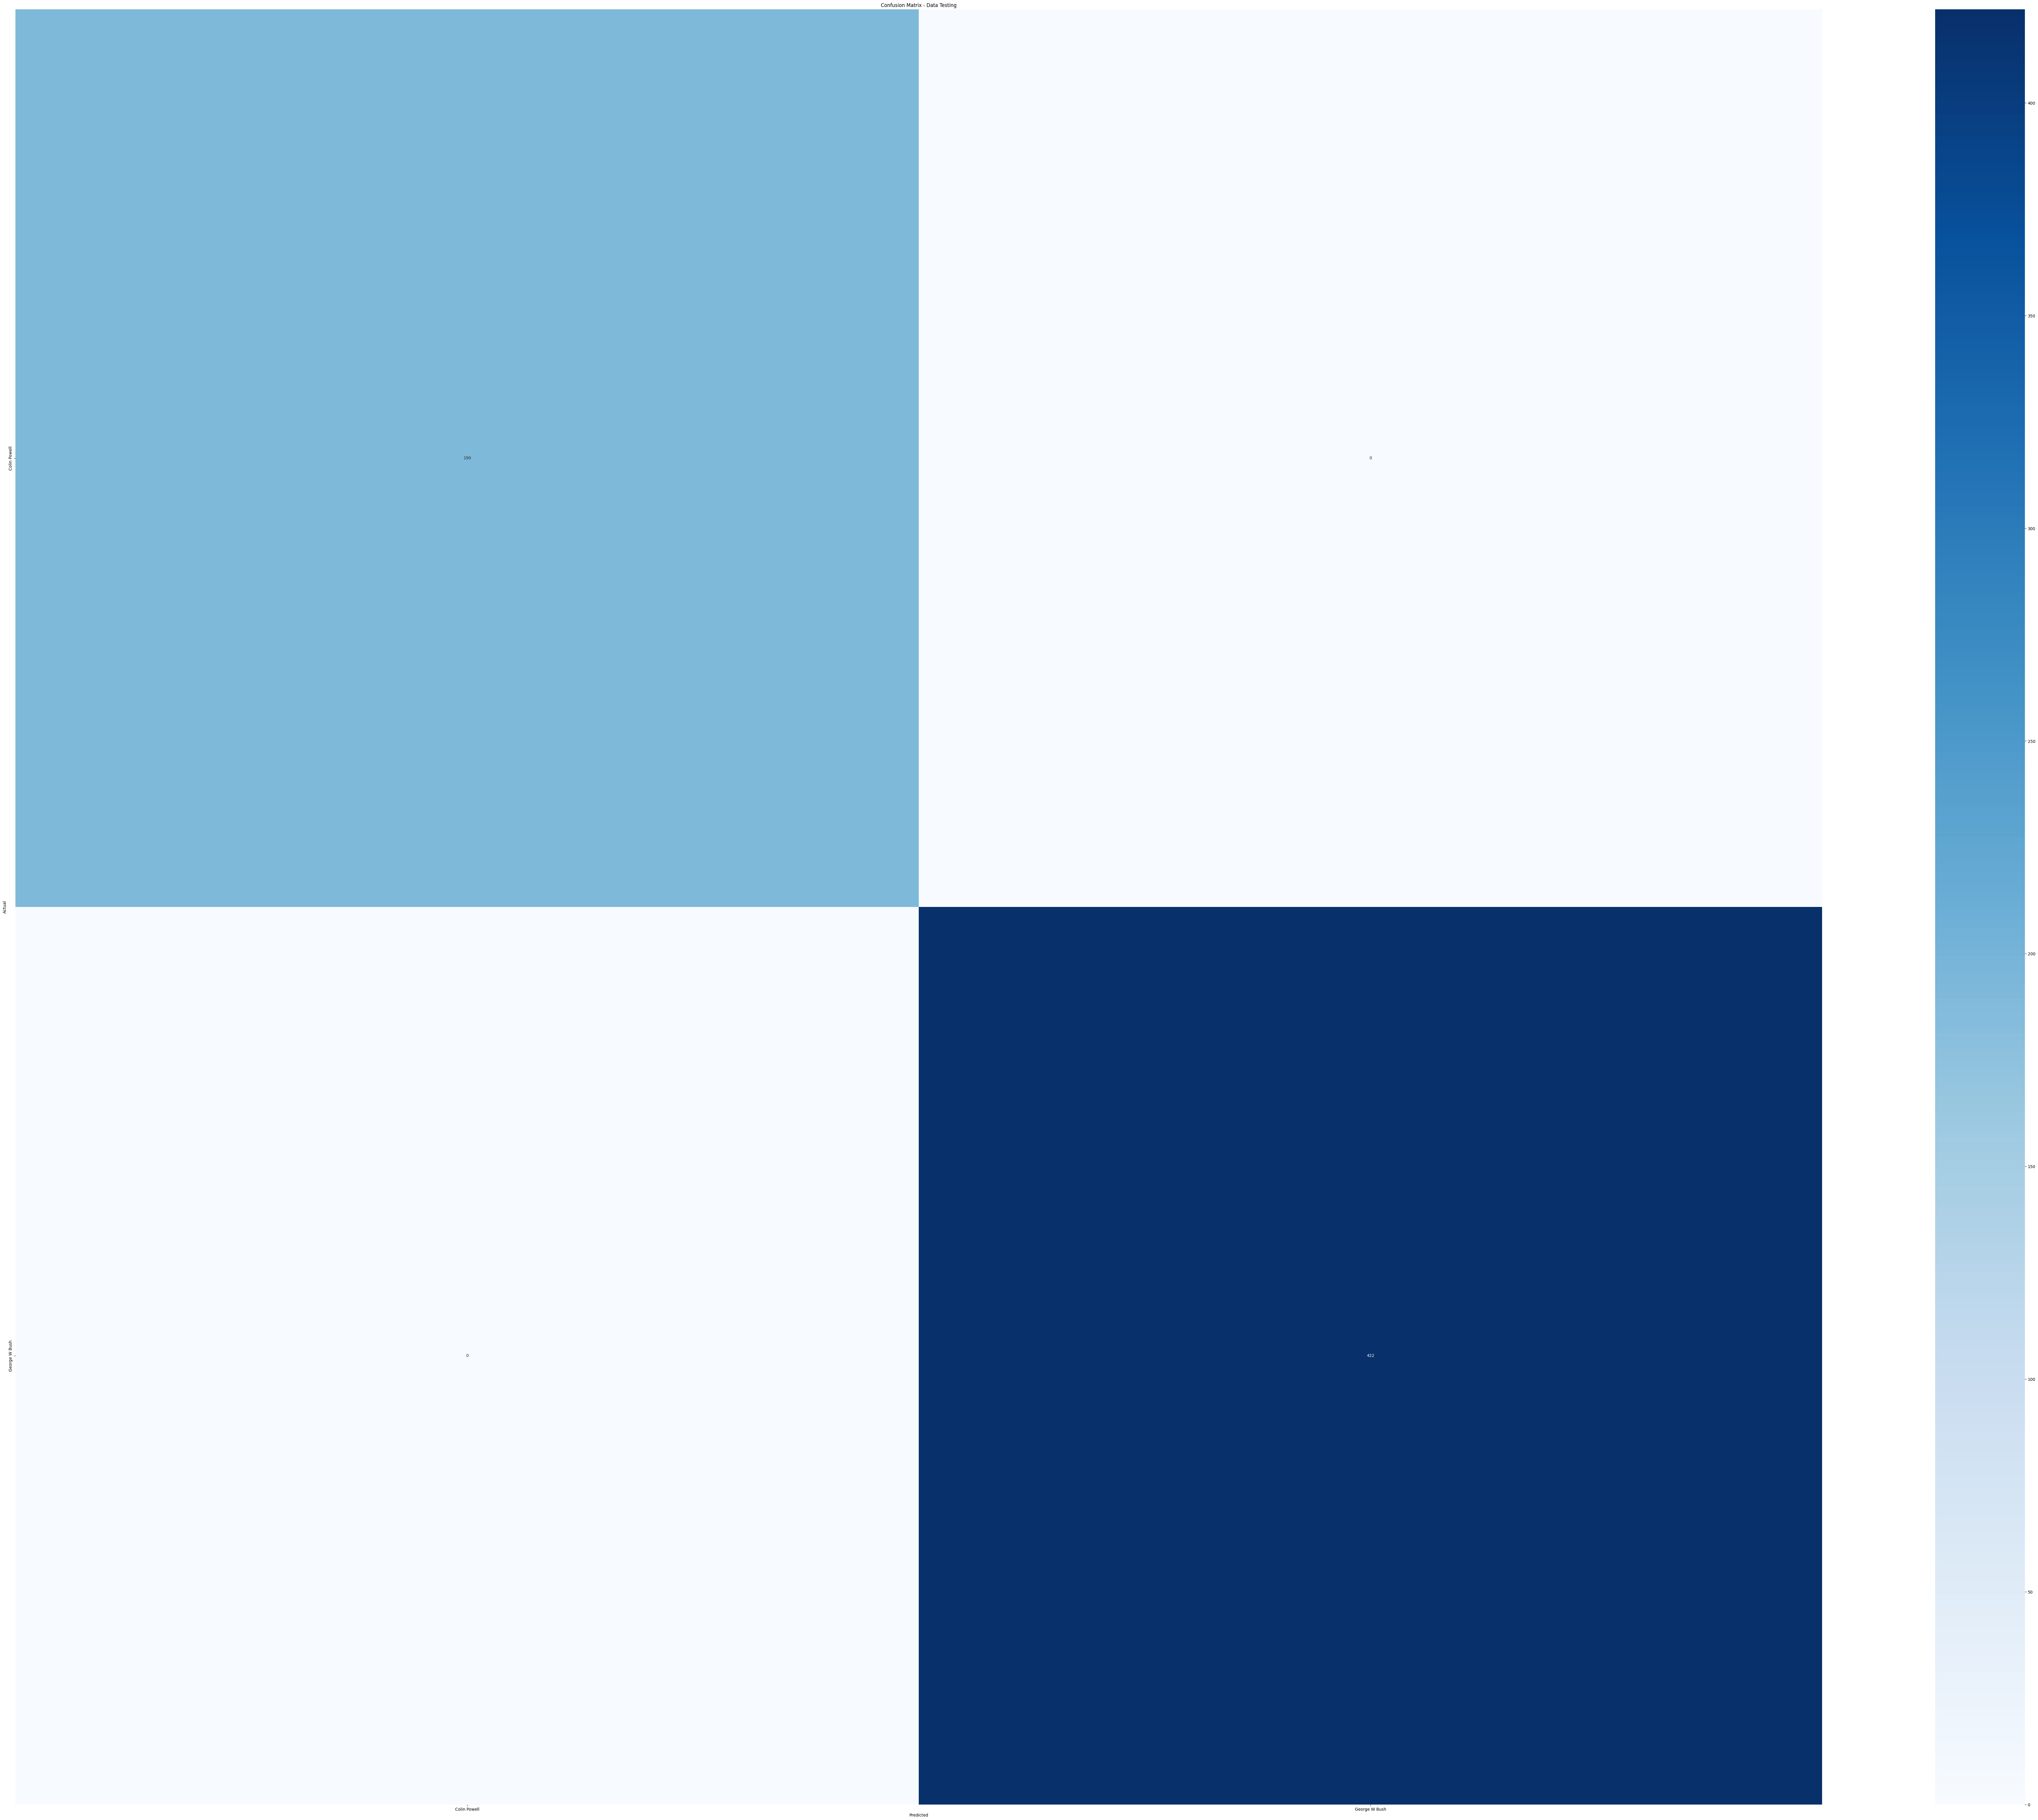

In [10]:
# 6. (Opsional) Evaluasi dengan Confusion Matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

# Visualisasi Confusion Matrix Data Train
plt.figure(figsize=(100, 80))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.title('Confusion Matrix - Data Testing')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

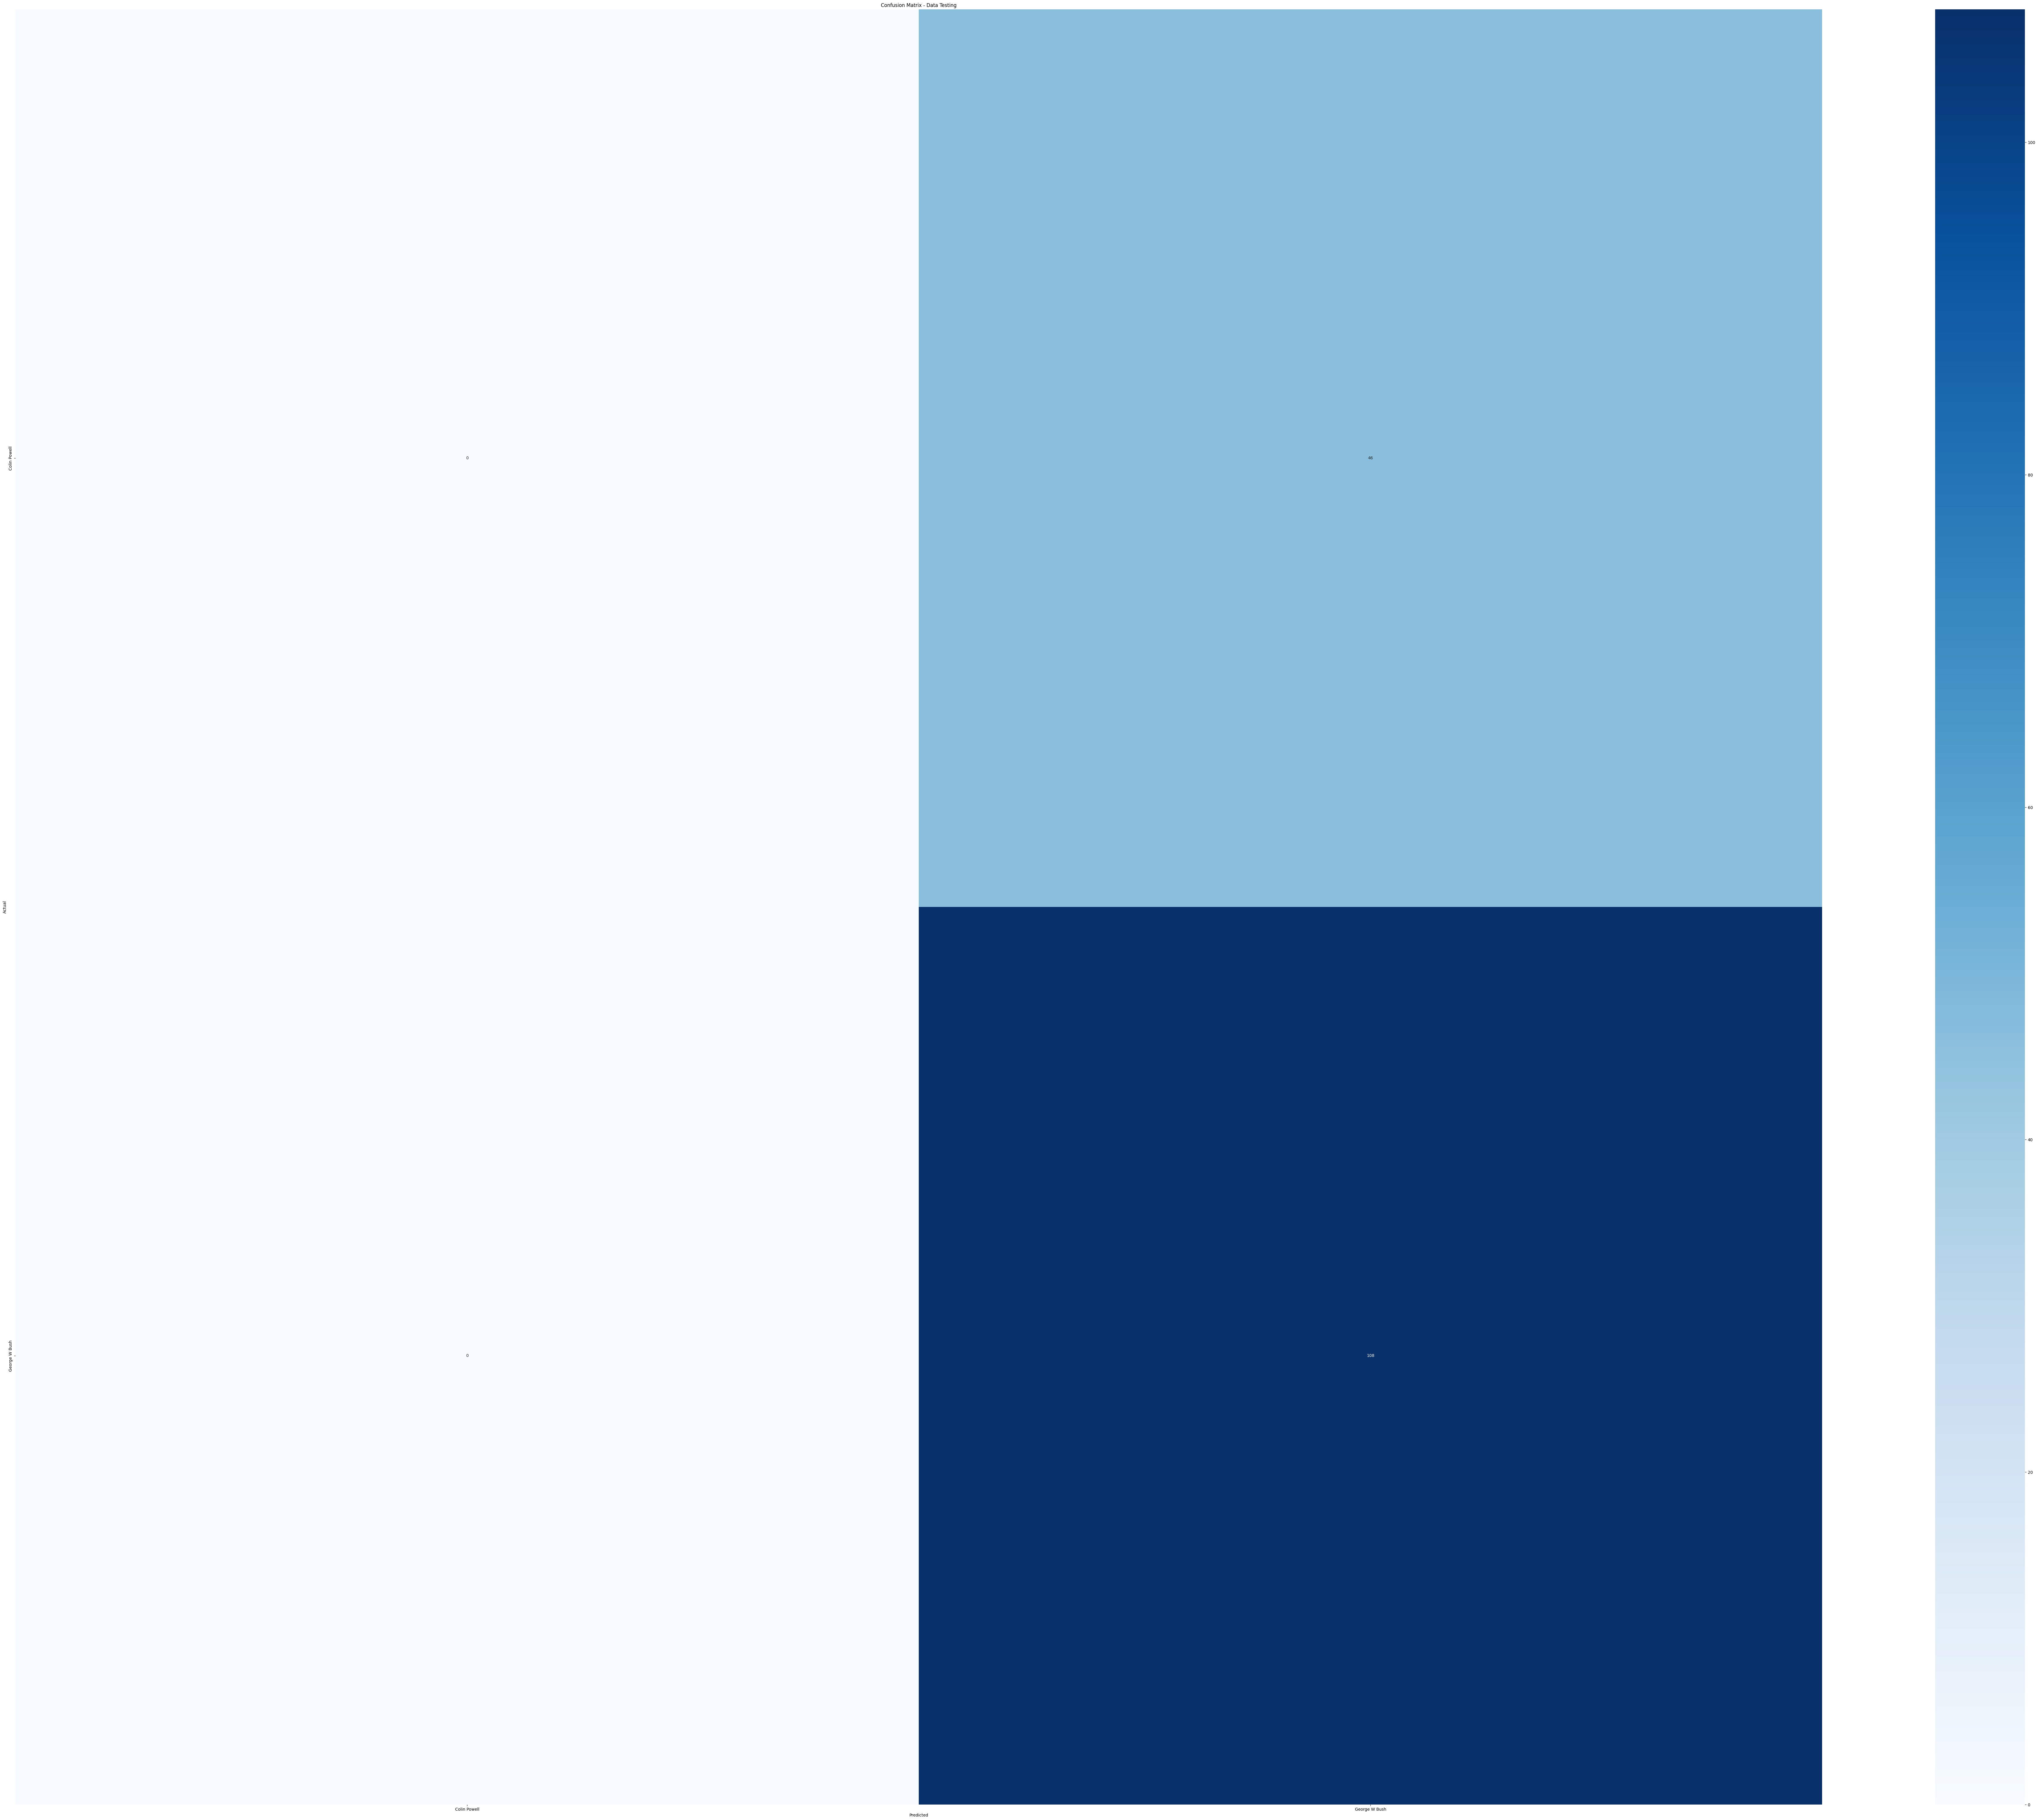

In [11]:
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Visualisasi Confusion Matrix Data Test
plt.figure(figsize=(100, 80))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.title('Confusion Matrix - Data Testing')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##Menggunakan model lain selain SVM (Optional)

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 2. Load Dataset seperti sebelumnya
faces = fetch_lfw_people(min_faces_per_person=200, color=True)

# Flatten data, convert each image into a feature vector
n_samples, h, w, _ = faces.images.shape
X = faces.data  # Data sudah diflatten (diubah jadi 2D) oleh fetch_lfw_people
y = faces.target

# 3. Split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Standardisasi data sebelum PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Lakukan PCA untuk mereduksi dimensi fitur
pca = PCA(n_components=150)  # Pilih 150 komponen utama sebagai contoh
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape setelah PCA (Training): {X_train_pca.shape}")
print(f"Shape setelah PCA (Testing): {X_test_pca.shape}")

Shape setelah PCA (Training): (612, 150)
Shape setelah PCA (Testing): (154, 150)


###Model Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

# 1. Build model Random Forest
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Fit model pada data PCA
rfc_model.fit(X_train_pca, y_train)

# 3. Prediksi pada data testing
y_test_pred_rfc = rfc_model.predict(X_test_pca)

# 4. Evaluasi model
test_accuracy_rfc = accuracy_score(y_test, y_test_pred_rfc)
print(f'Akurasi pada data testing (Random Forest): {test_accuracy_rfc * 100:.2f}%')

print("\nLaporan Klasifikasi pada Data Testing (Random Forest):\n")
print(classification_report(y_test, y_test_pred_rfc, target_names=faces.target_names))

Akurasi pada data testing (Random Forest): 81.82%

Laporan Klasifikasi pada Data Testing (Random Forest):

               precision    recall  f1-score   support

 Colin Powell       1.00      0.40      0.58        47
George W Bush       0.79      1.00      0.88       107

     accuracy                           0.82       154
    macro avg       0.90      0.70      0.73       154
 weighted avg       0.86      0.82      0.79       154



###Model K-Nearest Neighbors (KNN)

In [14]:
from sklearn.neighbors import KNeighborsClassifier

# 1. Build model K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)

# 2. Fit model pada data PCA
knn_model.fit(X_train_pca, y_train)

# 3. Prediksi pada data testing
y_test_pred_knn = knn_model.predict(X_test_pca)

# 4. Evaluasi model
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
print(f'Akurasi pada data testing (KNN): {test_accuracy_knn * 100:.2f}%')

print("\nLaporan Klasifikasi pada Data Testing (KNN):\n")
print(classification_report(y_test, y_test_pred_knn, target_names=faces.target_names))

Akurasi pada data testing (KNN): 88.96%

Laporan Klasifikasi pada Data Testing (KNN):

               precision    recall  f1-score   support

 Colin Powell       0.88      0.74      0.80        47
George W Bush       0.89      0.95      0.92       107

     accuracy                           0.89       154
    macro avg       0.88      0.85      0.86       154
 weighted avg       0.89      0.89      0.89       154



###Model Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

# 1. Build model Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# 2. Fit model pada data PCA
lr_model.fit(X_train_pca, y_train)

# 3. Prediksi pada data testing
y_test_pred_lr = lr_model.predict(X_test_pca)

# 4. Evaluasi model
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
print(f'Akurasi pada data testing (Logistic Regression): {test_accuracy_lr * 100:.2f}%')

print("\nLaporan Klasifikasi pada Data Testing (Logistic Regression):\n")
print(classification_report(y_test, y_test_pred_lr, target_names=faces.target_names))


Akurasi pada data testing (Logistic Regression): 93.51%

Laporan Klasifikasi pada Data Testing (Logistic Regression):

               precision    recall  f1-score   support

 Colin Powell       0.89      0.89      0.89        47
George W Bush       0.95      0.95      0.95       107

     accuracy                           0.94       154
    macro avg       0.92      0.92      0.92       154
 weighted avg       0.94      0.94      0.94       154

